In [1]:
from astropy.io import ascii
import numpy as np
import gurobipy as gp
from gurobipy import *
import random

Placa_madre = ascii.read("Opti - Placa Madre (1).dat")
Memorias = ascii.read("Opti - RAM (2).dat")
Almacenamiento = ascii.read("Opti - Almacenamiento SSD (3).dat")
Procesador = ascii.read("Opti - Procesador (4).dat")
Fuente_de_poder = ascii.read("Opti - Fuente de poder (5).dat")
Tarjeta_de_video = ascii.read("Opti - Tarjeta de video (6).dat")
Gabinete = ascii.read("Opti - Gabinete (7).dat")

Componentes = [Placa_madre, Memorias, Almacenamiento, Procesador, Fuente_de_poder, Tarjeta_de_video, Gabinete]
comps = ["Placa madre", "Memoria", "SSD", "CPU", "Fuente de poder", "Tarjeta de video", "Gabinete"]
tiendas = ['Las Condes','Manuel Montt','Mall Arauco Maipu','Mall Plaza Alameda','Chillan']

# Conjunto de componentes
I_ = range(0, 7) 

# Conjunto de modelos
M_ = [range(0, len(Componentes[0])),range(0, len(Componentes[1])),range(0, len(Componentes[2])),
     range(0, len(Componentes[3])),range(0, len(Componentes[4])),range(0, len(Componentes[5])), range(0, len(Componentes[6]))]

# Conjunto de tiendas
T_ = range(0, 5)

# Costo de cada componente
c = {(i,m,t) : Componentes[i]['Precio ($)'][m] for i in I_ for m in M_[i] for t in T_}

# Costo de envio de la tienda T. En este caso, como solo tomamos datos de PCFactory los costos de envio se asumen nulos
k = {t : 0 for t in T_}

# Potencia de los componentes
p = {(i,m): Componentes[i]['Potencia (W)'][m] for i in [0,1,3,4,5] for m in M_[i]}

# Especificacion de los componentes
e = {(i,m): Componentes[i]['Especificacion'][m] for i in [1,2,3,5] for m in M_[i]}

#---------------------------------------------------------#
#-----------Especificaciones------------------------------#
E = {1: 8, 2: 500, 3: 6*2.9, 5: 4} #----------------------#
#---------------------------------------------------------#
#---------------------------------------------------------#

# Espacios disponibles de ram en la placa madre
r = {m: Componentes[0]['Slots de memoria'][m] for m in M_[0]}

# Espacios de almacenamientos en la placa madre
a = {m: Componentes[0]['Almacenamiento'][m] for m in M_[0]}

# Stock en las sucursales
S = {(i,m,t): Componentes[i][tiendas[t]][m] for i in I_ for m in M_[i] for t in T_}

# Factor de forma
f = {(i,m): Componentes[i]['Factor de forma'][m] for i in [0,4,6] for m in M_[i]}

# Largo del componente
tam = {(i,m): Componentes[i]['Tamano de tarjeta'][m] for i in [5,6] for m in M_[i]}

# Ancho del componente
sl = {(i,m): Componentes[i]['Uso de slots'][m] for i in [5,6] for m in M_[i]}

#Conjunto de modelos de componentes incompatibles con el modelo m de la placa madre
R = {(1,m): [i for i in range(len(Componentes[1]['Precio ($)'])) if 
             Componentes[1]['Tipo de memoria'][i] != Componentes[0]['Tipo de memoria'][m] or
             Componentes[1]['Frecuencia (MHz)'][i] < Componentes[0]['Velocidad minima (MHz)'][m] or
             Componentes[1]['Frecuencia (MHz)'][i] > Componentes[0]['Velocidad maxima (MHz)'][m]   
            ]
             for m in M_[0]}

for m in M_[0]:
    R[3,m] = [i for i in range(len(Componentes[3]['Precio ($)'])) if 
             Componentes[3]['Marca'][i] != Componentes[0]['Plataforma'][m]]

# Conjunto de memorias ram incompatibles con el modelo m del procesador
H = {(1,m): [i for i in range(len(Componentes[1]['Precio ($)'])) if 
             Componentes[1]['Frecuencia (MHz)'][i] > Componentes[3]['Velocidad maxima (MHz)'][m] or
             Componentes[1]['Tipo de memoria'][i] != Componentes[3]['Tipos de memoria'][m] + ' DIMM']
             for m in M_[3]}

# Limite de precio para que el envio sea gratis. Nuevamente en este caso se asume nulo
phi = {t: 1 for t in T_}

#tuplas de componentes
l = []
for i in I_:
    for m in M_[i]:
        for t in T_:
            l.append((i,m,t))
            

In [2]:
# MODELO
model = Model("Costo_Mínimo_Computador")
            
# -------------------------------------------
# DEFINICIÓN DE VARIABLES
x = model.addVars(l,vtype = GRB.INTEGER, name = "Componente", lb = 0.0)
y = model.addVars(T_,vtype = GRB.BINARY, name = "envio")
z = model.addVars(T_,vtype = GRB.BINARY, name = "envio_gratis")

# -------------------------------------------
# RESTRICCIONES

# Se debe comprar solo una unidad de algunos componentes
model.addConstrs((quicksum(quicksum(x[i,m,t] for m in M_[i]) for t in T_) == 1 for i in [0,3,4,6]), name = "Componentes_unitarios")

# Se debe comprar a lo mas una tarjeta de video
model.addConstrs((quicksum(quicksum(x[i,m,t] for m in M_[i]) for t in T_) <= 1 for i in [5]), name = "Componentes_unitarios")

# Respetar el limite de espacios de RAM en la placa madre
model.addConstr((quicksum(quicksum(x[1,m,t] for m in M_[1]) for t in T_) <= quicksum(quicksum(r[m] * x[0,m,t] for m in M_[0]) for t in T_)), name = "Respetar_RAM")

# Respetar el limite de espacios de almacenamiento en la placa madre
model.addConstr((quicksum(quicksum(x[2,m,t] for m in M_[2]) for t in T_) <= quicksum(quicksum(a[m] * x[0,m,t] for m in M_[0]) for t in T_)), name = "Respetar_almacenamiento")

# Especificaciones
model.addConstrs((quicksum(quicksum(e[i,m] * x[i,m,t] for m in M_[i]) for t in T_) >= E[i] for i in [1,2,3,5]), name = "Especificaciones_minimas")

# Respetar el limite de potencia
model.addConstr((quicksum(quicksum(quicksum(p[i,m] * x[i,m,t] for m in M_[i]) for t in T_) for i in [0,1,3,4,5]) >= 0), name = "Respetar_limite_potencia")

# Cobrar envio
A = 1e10
model.addConstrs((quicksum(quicksum(x[i,m,t] for m in M_[i]) for i in I_) <= A * y[t] for t in T_), name = "cobrar_envio")

# envio grtis
model.addConstrs((quicksum(quicksum(c[i,m,t] * x[i,m,t] for m in M_[i]) for i in I_) >= phi[t] * z[t] for t in T_), name = "Envio_gratis")

# compatibilidad placa madre con otros componentes
model.addConstrs((A*(1 - quicksum(x[0,m,t] for t in T_)) >= quicksum(x[i,k,t] for t in T_) for m in M_[0] for i in [1,3] for k in R[i,m]), name = "Compatibilidad_placa_madre")

# compatibilidad procesador con otros componentes
model.addConstrs((A*(1 - quicksum(x[3,m,t] for t in T_)) >= quicksum(x[i,k,t] for t in T_) for m in M_[3] for i in [1] for k in H[i,m]), name = "Compatibilidad_procesador")

# Respetar disponibilidad en tienda
model.addConstrs((x[i,m,t] <= S[i,m,t] for i in I_ for m in M_[i] for t in T_), name = 'Stock')

# Respetar factor de forma del gabinete
model.addConstrs((quicksum(quicksum(f[6,m]*x[6,m,t] for m in M_[6]) for t in T_) >= quicksum(quicksum(f[i,m]*x[i,m,t] for m in M_[i]) for t in T_) for i in [0,4]), name = 'Factor_de_forma')

# Respetar largo de tarjeta de video
model.addConstr((quicksum(quicksum(tam[6,m]*x[6,m,t] for m in M_[6]) for t in T_) >= quicksum(quicksum(tam[5,m]*x[5,m,t] for m in M_[5]) for t in T_)), name = 'Respetar_largo_tarjeta_de_video')

# Respetar ancho de tarjeta de video
model.addConstr((quicksum(quicksum(sl[6,m]*x[6,m,t] for m in M_[6]) for t in T_) >= quicksum(quicksum(sl[5,m]*x[5,m,t] for m in M_[5]) for t in T_)), name = 'Respetar_ancho_tarjeta_de_video')

# Comprar todos los componentes en un solo lugar
model.addConstr((quicksum(y[t] for t in T_) <= 1), name = 'Comprar_en_un_solo_lugar')


# Naturaleza variables
model.addConstrs((x[i,m,t] >= 0 for i in I_ for m in M_[i] for t in T_),name = "Naturaleza_x_it")
model.addConstrs((y[t] >= 0 for t in T_),name = "Naturaleza_y_it")                 
model.addConstrs((z[t] >= 0 for t in T_),name = "Naturaleza_z_ijt")  


Using license file C:\Users\franc\gurobi.lic
Academic license - for non-commercial use only


{0: <gurobi.Constr *Awaiting Model Update*>,
 1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>}

In [3]:
obj = quicksum((y[t] - z[t])*k[t]  + quicksum(quicksum(c[i,m,t] * x[i,m,t] for m in M_[i]) for i in I_) for t in T_)
                 
model.setObjective(obj, GRB.MINIMIZE)
                 

# Actualizar modelo
model.update()


# Optimizar
model.optimize()



#################################

Gurobi Optimizer version 9.0.3 build v9.0.3rc0 (win64)
Optimize a model with 2367 rows, 775 columns and 14030 nonzeros
Model fingerprint: 0x739f6cbb
Variable types: 0 continuous, 775 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+10]
  Objective range  [1e+04, 5e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+10]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 2163 rows and 629 columns
Presolve time: 0.06s
Presolved: 204 rows, 146 columns, 1282 nonzeros
Variable types: 0 continuous, 146 integer (119 binary)
Found heuristic solution: objective 671790.00000

Root relaxation: objective 5.606210e+05, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 560621.000    0    6 671790.000 560621.000  16.5%     -    0s
H    0     0    

In [52]:
for i in I_:
    for m in M_[i]:
        for t in T_:
            if x[i,m,t].x>0:
                print('Compra {} unidad/es de la {} ID {} en la sucursal en {}'.format(x[i,m,t].x,comps[i],Componentes[i]['ID'][m], tiendas[t]))
print('Con un costo total de {}'.format(model.objVal))                

Compra 1.0 unidad/es de la Placa madre ID 32917 en la sucursal en Las Condes
Compra 1.0 unidad/es de la Memoria ID 37040 en la sucursal en Las Condes
Compra 1.0 unidad/es de la SSD ID 29235 en la sucursal en Las Condes
Compra 1.0 unidad/es de la CPU ID 32738 en la sucursal en Las Condes
Compra 1.0 unidad/es de la Fuente de poder ID 25211 en la sucursal en Las Condes
Compra 1.0 unidad/es de la Tarjeta de video ID 29276 en la sucursal en Las Condes
Compra 1.0 unidad/es de la Gabinete ID 36559 en la sucursal en Las Condes
Con un costo total de 587130.0
0 4 0
1 10 0
2 14 0
3 10 0
4 1 0
5 7 0
6 1 0


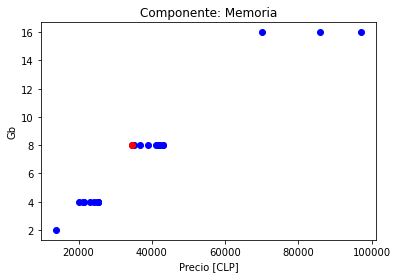

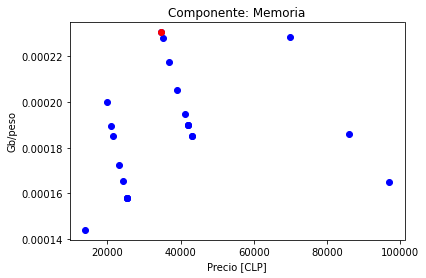

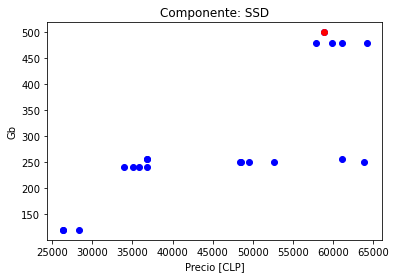

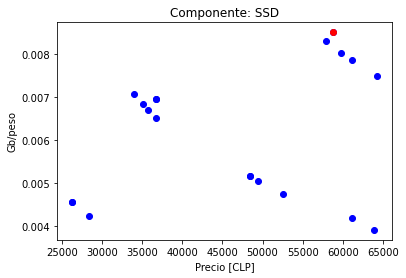

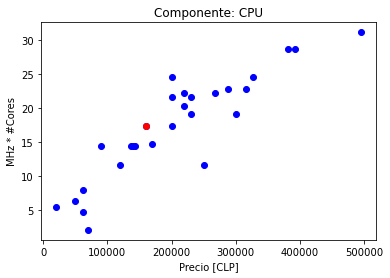

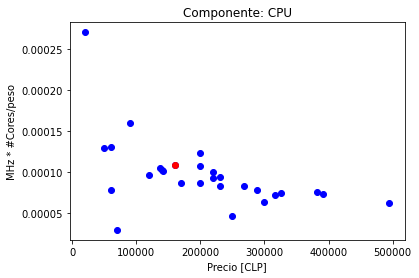

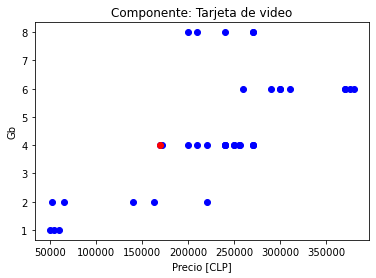

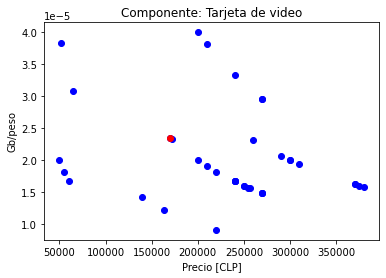

In [14]:
import pylab as plt

componente = 5


EjeY_peso = ['','Gb/peso', "Gb/peso", "MHz * #Cores/peso" ,'', "Gb/peso"]
EjeY = ['','Gb', "Gb", "MHz * #Cores" ,'', "Gb"]

for i in [1,2,3,5]:
    for m in M_[i]:
        for t in T_:
            if x[i,m,t].x>0:
                plt.figure()
                plt.plot(Componentes[i]['Precio ($)'],Componentes[i]['Especificacion'],'bo')
                plt.plot(Componentes[i]['Precio ($)'][m],Componentes[i]['Especificacion'][m],'ro')
                plt.title("Componente: {}".format(comps[i]))
                plt.xlabel("Precio [CLP]")
                plt.ylabel(EjeY[i])
                plt.figure()
                plt.plot(Componentes[i]['Precio ($)'],Componentes[i]['Especificacion']/Componentes[i]['Precio ($)'],'bo')
                plt.plot(Componentes[i]['Precio ($)'][m],Componentes[i]['Especificacion'][m]/Componentes[i]['Precio ($)'][m],'ro')
                plt.title("Componente: {}".format(comps[i]))
                plt.xlabel("Precio [CLP]")
                plt.ylabel(EjeY_peso[i])
                
                
                
plt.show()